In [ ]:
!pip install razdel pymorphy2

     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 8.2 MB 22.1 MB/s 


In [ ]:
import numpy as np
import pandas as pd

import itertools
import re
import pymorphy2
import nltk
import razdel # https://github.com/natasha/razdel

from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from functools import wraps, partial
from collections import defaultdict

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
parent_path = '/content/drive/MyDrive/Colab Notebooks/ml-buisness/lection2_materials/'

Mounted at /content/drive


### векторные представления новостей

In [ ]:
news = pd.read_csv(f"{parent_path}articles.csv")
news.head(3)

,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [ ]:
class LDABuilder:
  def __init__(self, addwords):
    # initialize stopwords list
    nltk.download('stopwords')
    stopwords = nltk.corpus.stopwords.words('russian')
    try:
      if addwords:
        with open(addwords) as f:
          additional_stopwords = [w.strip() for w in f.readlines() if w]
        stopwords += additional_stopwords
    except IOError as e:
      print(e)
    self.stopwords = stopwords
    # initialize morph analyzer
    self.morph = pymorphy2.MorphAnalyzer()    
    self.dictionary = None
    self.lda = None
    self.num_topics = 0
    self.cache = {}

  def stringarg(func):
    """ Recast argument to str if required """
    @wraps(func)
    def recast(self, arg):
      if not isinstance(arg, str):
        arg = str(arg)
      return func(self, arg)
    return recast

  @stringarg
  def __clean_text(self, text):
    """ Clean given text """
    # regex cleaner
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))
    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]    
    #return " ".join(words)
    return text

  @stringarg
  def __lemmatization(self, text):
    """ Lemmatization of given text 
        [0] токенизация предложения через razdel
        [1] проверка есть ли в начале слова '-'
        [2] проверка длины токена
        [3] проверка наличия данного слова в кэше
        [4] нормализация слова
        [5] фильтрация стоп-слов
    """
    # tokens = list(razdel.tokenize(text))
    words = [_.text for _ in razdel.tokenize(text)]   # [0]
    words_lem = []
    for word in words:
      if word[0] == '-': # [1]
        word = word[1:]
      if len(word) > 1: # [2]
        if word not in self.cache: # [3]
          self.cache[word] = self.morph.parse(word)[0].normal_form
        words_lem.append(self.cache[word])
        # if word in cache: # [3]
        #   words_lem.append(cache[word])
        # else: # [4]
        #   temp_cach = cache[word] = self.morph.parse(word)[0].normal_form
        #   words_lem.append(temp_cach)
    
    words_lem_without_stopwords = np.array([w for w in words_lem if w not in self.stopwords]) # [5]
    return words_lem_without_stopwords

  def build(self, X: pd.Series, **kwargs):
    """ Create LDA model """
    # read params
    self.num_topics = kwargs.pop('num_topics', 25)

    # process
    X = X.copy()
    X = X.apply(self.__clean_text)
    X = X.apply(self.__lemmatization)
    # create common corpus
    self.dictionary = Dictionary(X.tolist())
    corpus = X.apply(self.dictionary.doc2bow).tolist()
    # train the model on the corpus.
    self.lda = LdaModel(corpus, id2word=self.dictionary,
                        num_topics=self.num_topics, **kwargs)
  
  def prepare(self, X: pd.Series):
    """ Prepare data """
    X = X.copy()
    X = X.apply(self.__clean_text)
    X = X.apply(self.__lemmatization)
    return X

  def get_lda_vector(self, X: pd.Series, prepare=False):
    """ Get LDA vector for given items """
    X = X.copy()
    if prepare:
      X = X.apply(self.__clean_text)
      X = X.apply(self.__lemmatization)
    unseen_docs = X.apply(self.dictionary.doc2bow)
    lda_tuples = [self.lda[doc] for doc in unseen_docs]
    topics = [defaultdict(int, lt) for lt in lda_tuples]
    vectors = np.array([[topic[i] for i in range(self.num_topics)] for topic in topics])
    return vectors

  def get_topic_words(self, **kwargs):
    """ Get words of topics """
    # read params
    nwords = kwargs.get('words', 5)
    # process
    topics = self.lda.show_topics(num_topics=self.num_topics, num_words=nwords, formatted=False)
    topic_words = [(topic_num, [word for word, _ in words_proba_bundle]) for topic_num, words_proba_bundle in topics]
    # use this to print
    # for topic, words in topic_words:
    #   print(f'{topic}: ', *words)
    return topic_words

  def get_topic_matrix(self, X: pd.Series, ids: pd.Series, prepare=False):
    """ Get topic matrix """
    topic_matrix = pd.DataFrame(self.get_lda_vector(X, prepare=prepare), columns=[f'topic_{n}' for n in range(self.num_topics)])
    topic_matrix.insert(0, ids.name, ids.values)
    return topic_matrix

In [ ]:
# usage
%%time
lda_builder = LDABuilder(f'{parent_path}stopwords.txt')
lda_builder.build(news['title'], num_topics=25, passes=1, random_state=11)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: FutureWarning: Possible nested set at position 39


CPU times: user 6min 1s, sys: 28 s, total: 6min 29s
Wall time: 6min 9s


In [ ]:
# show topics
for t, w in lda_builder.get_topic_words(words=7):
  print(f'{t}: ', *w)

0:  nn препарат астероид законодательство телескоп след мужчина
1:  исследование ребёнок гражданин млн тыс пациент nn
2:  погибнуть товар дыра теория превысить мкс культурный
3:  фонд нефть государство глава медведев рынок баррель
4:  банк исследование китай ген запуск японский болезнь
5:  военный армия взрыв россия часть советский сила
6:  животное продукция производитель узнать вид считаться свет
7:  украина газ украинский киев миссия российский отряд
8:  сша санкция исследование лаборатория иран турция учёный
9:  космический аппарат космос операция система орбита древний
10:  сотрудник смерть тело убийство уголовный орган данные
11:  российский сша корабль самолёт спутник полёт россия
12:  экономика всё большой очень первый спрос земля
13:  население рынок министерство вопрос развитие проверка россия
14:  nn луна сша египет общество венесуэла нафтогаз
15:  пенсия фонд восток nn бензин грузия товарищ
16:  россия млрд рубль путин руб российский правительство
17:  учёный обнаружить опу

In [ ]:
%%time
# prepare news data
pnews = lda_builder.prepare(news['title'])

CPU times: user 3min 29s, sys: 768 ms, total: 3min 30s
Wall time: 3min 30s


In [ ]:
%%time
# topic_matrix = lda_builder.get_topic_matrix(news['title'], news['doc_id'], prepare=True)
topic_matrix = lda_builder.get_topic_matrix(pnews, news['doc_id'])
topic_matrix.head(5)

CPU times: user 39.6 s, sys: 15.3 s, total: 54.8 s
Wall time: 38 s


### векторные представления пользователей

In [ ]:
users = pd.read_csv(f"{parent_path}users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [ ]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix.drop(columns='doc_id').values))

In [ ]:
def get_user_embedding(user_articles_list, method=partial(np.mean, axis=0), weights=None):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    if weights:
      doc_w = np.array([weights[doc_id] for doc_id in user_articles_list])
      user_vector = (user_vector.T * doc_w).T   # то же самое, что np.array([vec * w for vec, w in zip(user_vector, doc_w)])
    user_vector = method(user_vector)
    return user_vector

In [ ]:
# usage
# get_user_embedding(users['articles'].iloc[33], method=partial(np.mean, axis=0))
# get_user_embedding(users['articles'].iloc[33], method=partial(np.median, axis=0))
# get_user_embedding(users['articles'].iloc[33], method=partial(np.max, axis=0))

In [ ]:
# embedding_func = partial(get_user_embedding, method=partial(np.median, axis=0), weights=doc_weights)
# embedding_func = partial(get_user_embedding, method=partial(np.median, axis=0))
embedding_func = partial(get_user_embedding, method=partial(np.mean, axis=0))
user_embeddings = pd.DataFrame([col for col in users['articles'].apply(embedding_func)])
user_embeddings.columns = [f'topic_{n}' for n in user_embeddings.columns]
user_embeddings.insert(0, 'uid', users['uid'].values)
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.051180,0.056193,0.063882,0.000000,0.063317,0.041180,0.066674,0.033322,0.000000,0.004596,0.047916,0.017262,0.009008,0.010344,0.004872,0.006649,0.065928,0.006396,0.172343,0.001698,0.057302,0.146381,0.048191,0.008527,0.0
1,u108690,0.014988,0.082188,0.019129,0.049123,0.011363,0.023185,0.004278,0.084264,0.023828,0.004510,0.099045,0.011446,0.035298,0.090951,0.010707,0.020182,0.084993,0.005300,0.086912,0.004675,0.139335,0.044957,0.016496,0.019762,0.0
2,u108339,0.006215,0.040981,0.008233,0.027260,0.015070,0.076417,0.000000,0.011610,0.002943,0.013593,0.129849,0.032718,0.023974,0.028905,0.112590,0.017110,0.108837,0.012917,0.087841,0.010609,0.072614,0.073031,0.017051,0.049527,0.0


In [ ]:
# загрузка разметки
target = pd.read_csv(f"{parent_path}users_churn.csv")
# merge
data = pd.merge(user_embeddings, target, 'left')
data.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.051180,0.056193,0.063882,0.000000,0.063317,0.041180,0.066674,0.033322,0.000000,0.004596,0.047916,0.017262,0.009008,0.010344,0.004872,0.006649,0.065928,0.006396,0.172343,0.001698,0.057302,0.146381,0.048191,0.008527,0.0,0
1,u108690,0.014988,0.082188,0.019129,0.049123,0.011363,0.023185,0.004278,0.084264,0.023828,0.004510,0.099045,0.011446,0.035298,0.090951,0.010707,0.020182,0.084993,0.005300,0.086912,0.004675,0.139335,0.044957,0.016496,0.019762,0.0,1
2,u108339,0.006215,0.040981,0.008233,0.027260,0.015070,0.076417,0.000000,0.011610,0.002943,0.013593,0.129849,0.032718,0.023974,0.028905,0.112590,0.017110,0.108837,0.012917,0.087841,0.010609,0.072614,0.073031,0.017051,0.049527,0.0,1


### пайплайн для дз

In [ ]:
class DoMyHomeworkPlease:
  def __init__(self, topic_matrix, embedding_stat_funcs, func_labels=[], doc_weights=None):
    self.embedding_stat_funcs = embedding_stat_funcs
    self.func_labels = func_labels if func_labels else [f'function {n}' for n in range(len(embedding_stat_funcs))]
    self.doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix.drop(columns='doc_id').values))
    self.doc_weights = doc_weights

  def get_user_embedding(self, user_articles_list, method, apply_weights=False):
      user_articles_list = eval(user_articles_list)
      user_vector = np.array([self.doc_dict[doc_id] for doc_id in user_articles_list])     # `тематический профиль` для каждой прочитанной пользователем статьи
      if apply_weights:
        doc_w = np.array([self.doc_weights[doc_id] for doc_id in user_articles_list])
        user_vector = (user_vector.T * doc_w).T   # то же самое, что np.array([vec * w for vec, w in zip(user_vector, doc_w)])
      user_vector = method(user_vector)     # выбор доминанты(статистики) по каждой теме: построение профиля пользователя
      return user_vector

  def build_dataset(self, X, target, embedding_func):
    """ Build dataset using given embedding function """
    uid = X['uid'].copy()
    user_embeddings = pd.DataFrame([elem for elem in X['articles'].apply(embedding_func)])
    user_embeddings.columns = [f'topic_{n}' for n in user_embeddings.columns]
    user_embeddings.insert(0, 'uid', uid.values)
    data = pd.merge(user_embeddings, target, 'left')
    return data

  def gogogo(self, X, target, apply_weights=False, rs=None):
    """ pipeline: Build dataset -> Fit model & predict -> Calculate metrics -> Save results """
    results = []
    for func, label in zip(self.embedding_stat_funcs, self.func_labels):
      embedding_func = partial(self.get_user_embedding, method=func, apply_weights=apply_weights)
      data = self.build_dataset(X, target, embedding_func)
      # split dataset
      split_rs = rs + 2 if rs else None
      X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['uid', 'churn']), data['churn'], random_state=split_rs)
      # fit model
      # logreg = LogisticRegression(max_iter=150,
      #                       class_weight='balanced',
      #                       random_state=rs)
      logreg = SGDClassifier(random_state=rs,
                             max_iter=150,
                             learning_rate='adaptive',
                             eta0=0.25,
                             loss='modified_huber',
                             class_weight='balanced',
                             n_jobs=-1,
                             )
      logreg.fit(X_train, y_train)
      # test predict
      preds_proba = logreg.predict_proba(X_test)[:, 1]
      preds = logreg.predict(X_test)

      # calculate metrics
      precision, recall, thresholds = precision_recall_curve(y_test, preds_proba)
      fscore = (2 * precision * recall) / (precision + recall)
      ix = np.argmax(fscore)
      results.append([roc_auc_score(y_test, preds_proba), precision[ix], recall[ix], fscore[ix], thresholds[ix]])
    
    basic = pd.DataFrame(results, columns=['roc auc', 'precision', 'recall', 'f-score', 'threshold'], index=self.func_labels)
    ext = self.gogogo(X, target) if self.doc_weights and apply_weights else pd.DataFrame()
    if not ext.empty:
      basic.index = [f'weighted {row}' for row in self.func_labels]
    return pd.concat([ext, basic])

In [ ]:
articles = pnews.apply(lambda x: ' '.join(x)).tolist()
vectorizer = TfidfVectorizer()
tfvec = vectorizer.fit_transform(articles)    # `матрица значимости` по tf-idf слов в документе.

# calculate tf-idf-based weights for news
# по манхеттенской норме
# w = np.array([np.linalg.norm(tfvec.getrow(i).toarray()[0], ord=1) for i in range(tfvec.shape[0])])   # toarray()[0]: indexing for reshape
# w = normalize([w]).reshape(tfvec.shape[0])    # normalized weights
# w = w / w.max()         # relative weights

# по норме Чебышева - просто из интереса (не работает на mean и median - в precision появляется 0 ближе к концу, из-за чего возникает DivisionByZero)
# w = np.array([np.linalg.norm(tfvec.getrow(i).toarray()[0], ord=np.inf) for i in range(tfvec.shape[0])])   # toarray()[0]: indexing for reshape
# w = normalize([w]).reshape(tfvec.shape[0])    # normalized weights
# w = w / w.max()       # relative weights

# по евклидовой норме эти веса будут равны 1
# w = np.array([np.linalg.norm(tfvec.getrow(i).toarray()[0], ord=2) for i in range(tfvec.shape[0])])   # toarray()[0]: indexing for reshape
# doc_weights = dict(zip(news['doc_id'], w))

In [ ]:
# calculate idf-based weights for news
# словарь {слово: idf}
vocab = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))
# замена слов на их idf в dataframe
doc_idf = pnews.apply(lambda x: [vocab[w] if w in vocab.keys() else 0 for w in x])
# расчет relative весов по idf слов в документе
w = doc_idf.apply(partial(np.linalg.norm, ord=1))       # Манхэттен
# w = doc_idf.apply(partial(np.linalg.norm, ord=2))       # Евклид
# w = doc_idf.apply(partial(np.linalg.norm, ord=np.inf))  # Чебышев
w = w / w.max()
# w = normalize([w]).reshape(tfvec.shape[0])
doc_weights = dict(zip(news['doc_id'], w))

In [ ]:
# usage
hw = DoMyHomeworkPlease(topic_matrix,
                        [partial(np.mean, axis=0), partial(np.median, axis=0), partial(np.max, axis=0)],
                        func_labels=['mean', 'median', 'max'],
                        doc_weights=doc_weights
                        )
hw.gogogo(users, target, apply_weights=True, rs=19)
# hw.gogogo(users, target, apply_weights=True)

,roc auc,precision,recall,f-score,threshold
mean,0.958203,0.636364,0.801527,0.709459,0.662839
median,0.984460,0.826568,0.851711,0.838951,0.676405
max,0.975197,0.838710,0.809339,0.823762,0.818616
weighted mean,0.996673,0.929961,0.995833,0.961771,0.523775
weighted median,0.999991,0.991736,1.000000,0.995851,0.436449
weighted max,0.983817,0.777027,0.958333,0.858209,0.584137


Наблюдения
1. Для любого из предложеенных методов взвешивания, взвешенный результат дает лучшую метрику, чем невзвешенный
2. "Относительное" взвешивание в данной реализации дает лучшую метрику, чем нормализованное

лучший результат:
IDF+манхэттен(rel)+median

Косяки:
1. Иногда всплывает `DivisionByZero` из-за появления нуля в предпоследнем (или около) значении `precision` при расчете `precision_recall_curve`. В причинах еще не разобрался.

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

### обучение модели

In [ ]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['uid', 'churn']), data['churn'], random_state=17)

# обучим 
# logreg = LogisticRegression(# max_iter=150,
#                             # class_weight='balanced',
#                             random_state=23)
logreg = SGDClassifier(random_state=23,
                       max_iter=150,
                       learning_rate='adaptive',
                       eta0=0.25,
                       loss='modified_huber',
                       class_weight='balanced',
                       n_jobs=-1,
                       )
logreg.fit(X_train, y_train)

#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.        , 0.75515342, 0.45192074, 0.        , 0.        ,
       0.5948847 , 0.        , 0.30303259, 0.        , 0.        ])

### Рассчитаем Precision, Recall, F_score

#### plot funcs

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### info

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.706852, F-Score=0.694, Precision=0.647, Recall=0.747


Confusion matrix, without normalization
[[1661   98]
 [  62  179]]


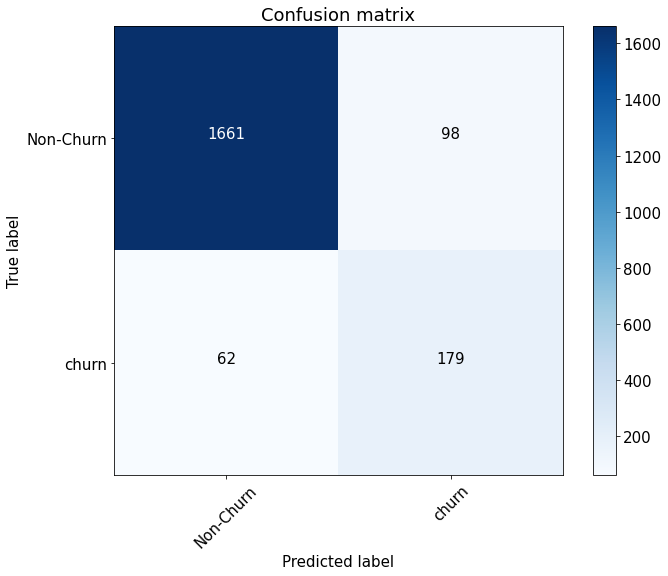

In [ ]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
roc_auc_score(y_test, preds)

0.9513090944260579